# Script to explore finding and fitting transits with LightKurve and other packages
### Last modified 6/25/21 by Anna Zuckerman


In [ ]:
!pip install lightkurve

In [128]:
# import packages
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [129]:
# search for and download all observations
search_result = lk.search_lightcurve('Kepler-69', author='Kepler', cadence='long')
lc_collection = search_result.download_all()

# stitch together, flatten, and normalize all observations
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()

Text(0.5, 1.0, 'Kepler-69 b')

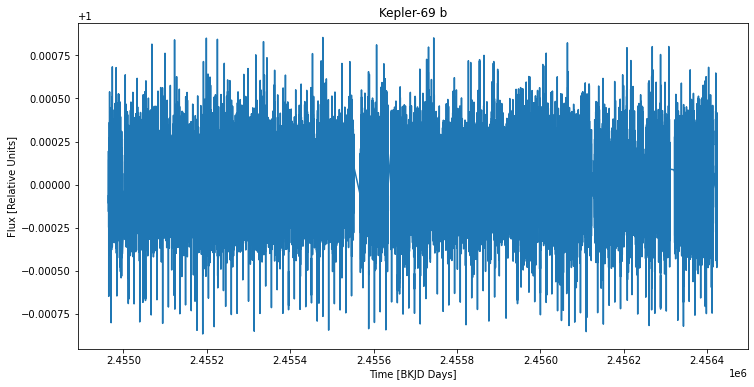

In [130]:
# plot lightcurve
flux = lc.flux.value           # Flux [relative units]
time = lc.time.value + 2454833 # Time  [BKJD days]
err = lc.flux_err.value        # Uncertainty in flux
plt.figure(figsize = [12,6])
plt.plot(time, flux)
plt.xlabel('Time [BKJD Days]')
plt.ylabel('Flux [Relative Units]')
plt.title('Kepler-69 b')


In [132]:
# Known properties of the transit from NASA Exoplanet Archive
# [NOTE: NEED TO DO THIS PROGRAMATICALLY!]

period = 13.722                               # Days
t0 = 2454970.84                               # Days
R_p = 2.28                                    # Earth radii
R_star = 1.04                                 # Ro [NOTE: this is an average of exoplanet archive values]
R_p_star = (R_p * 6378.14)/(R_star * 696340)  # Rp/R* 
a = 0.10                                      # AU
inc = 89.4                                    # Inclination [deg]
ecc = 0                                       # Ecentricity (NOTE: Barclay et al. 2013 says 0.16 +0.17/-0.001)
#w = #???                                     # [NOT LISTED IN NASA TABLE]
#u = #???                                     # [NOT LISTED IN NASA TABLE]
#limb_darkening_model = 'quadratic'
impact_parameter = 0.254                      # NOTE: This is mode but varies widely in NASA Exoplanet Archive table

## Fit transits as Gaussians

2455557.4555
2455564.3164999997
2455568.3839081116
2455552.548371795
-15.83553631650284


ValueError: `ydata` must not be empty!

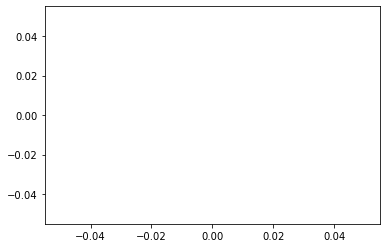

In [267]:
# fit guassian to transits using known t0 as guessed location

def fit_gaussian(transit_idx, to_plot):

    # area around expected transit
    low_bound = t0 + period * transit_idx - period/4     # /4 is somewhat arbitrary
    up_bound = t0 + period * transit_idx + period/4
    interval = (low_bound < time)*(time < up_bound)
    # all intervals are ~same in time duration, but not in number of steps/pixels
    testing =1
    if testing:
        time_interval = np.max(time[time < up_bound]) -  np.min(time[time > low_bound])
        print(low_bound); print(up_bound)
        print(np.min(time[time > low_bound])); print(np.max(time[time < up_bound]))
        print(time_interval)
        plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
    if interval > 5: # the last interval won't necessarily contain a full transit; threshold somewhat arbitrary
        length = len(time[interval])

        # fit a guassian to the transit
        def gaussian(x, a, b, c):
            return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))
        guess_params =[-0.1, t0 + period * transit_idx, 0.1] # somewhat arbitrary, but seems like a < 0 works, b = t0, and 0.01 < c < 10 
        pars, cov = curve_fit(f=gaussian, xdata=time[interval], ydata=flux[(interval)]-1, p0 = guess_params, bounds=(-np.inf, np.inf), maxfev = 80000)
        model_gaussian = pars[0]*np.exp((-(time[interval]-pars[1])**2)/(2*pars[2])**2) + 1
        RMSE = np.sqrt(np.sum((flux[interval] - model_gaussian)**2/length))

        if to_plot:   
            plt.figure(figsize = [12,6])
            plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
            plt.plot(time[interval],model_gaussian, label = 'Guassian fit')
            plt.legend()
            plt.xlabel('Time [BKJD Days]')
            plt.ylabel('Flux [Relative Units]')
            plt.title('Kepler-69 b, transit ' + str(transit_idx))
            print('Gaussian parameters for transit ' + str(transit_idx) +':')
            print('     a = ' + str(np.round(pars[0],4)))
            print('     b = ' + str(np.round(pars[1],3)))
            print('     c = ' + str(np.round(pars[2],4)))
            print('     RMSE = ' + str(np.round(RMSE,4)))
            print()
        return(pars)
    else: 
        return np.nan
#for i in range(0,106,1):
#    print(i)
#    pars = fit_gaussian(i,0)

pars = fit_gaussian(43,1)

(2455552.4555, 2455569.3164999997)

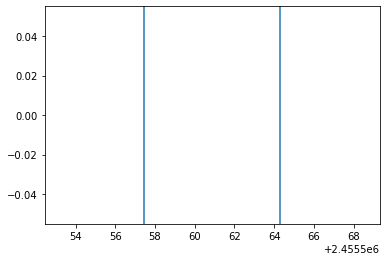

In [276]:
transit_idx = 43
low_bound = t0 + period * transit_idx - period/4     # /4 is somewhat arbitrary
up_bound = t0 + period * transit_idx + period/4
interval = (low_bound < time)*(time < up_bound)
plt.plot(time[interval],flux[interval], '.', markersize = 5,label = 'Kepler-69b Data')
plt.axvline(low_bound)
plt.axvline(up_bound)
plt.xlim([low_bound-5, up_bound + 5])

In [ ]:
# how far is each transit from the expected location and depth?
num_transits = (time - 2454833) 


## Fit transits with ktransit
#### Modified from tutorial at https://github.com/mrtommyb/ktransit

In [134]:
!pip install ktransit

Defaulting to user installation because normal site-packages is not writeable


In [135]:
import ktransit
from ktransit import FitTransit

Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454970.8648303584
rprs: 0.022903738413710774



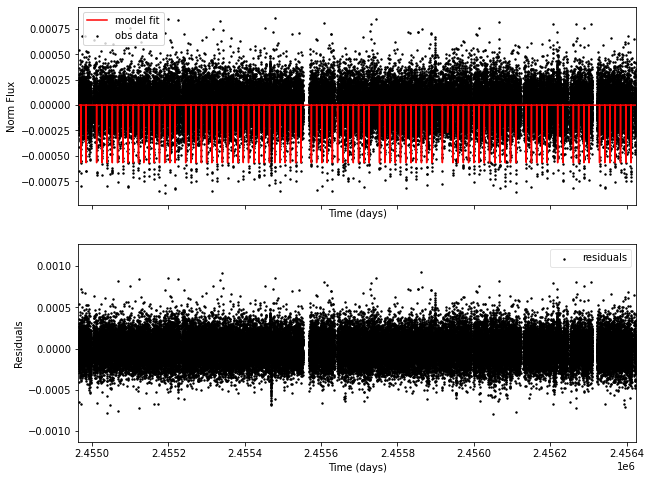

In [147]:
# fit the entire lightcurve

fitT = FitTransit()
fitT.add_guess_star()    
fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0, rprs=R_p_star)
fitT.add_data(time=time, flux=flux -1, ferr=err)

vary_star = []                     # free stellar parameters
vary_planet = (['T0',  'rprs'])    # free planetary parameters

fitT.free_parameters(vary_star, vary_planet)
fitT.do_fit()                      # run the fitting

fitT.print_results()               # print some results

fig = ktransit.plot_results(time,flux-1,fitT.transitmodel) 
fig.show()

Transit 0:
Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454984.5498487907
rprs: 0.021751589340761428

RMSE = 0.0002

Transit 10:
Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454984.586199714
rprs: 0.023348081519159493

RMSE = 0.0001

Transit 100:
Best-fitting stellar parameters

Best-fitting planet parameters for planet 0
T0: 2454984.599323125
rprs: 0.02349848613873538

RMSE = 0.0002



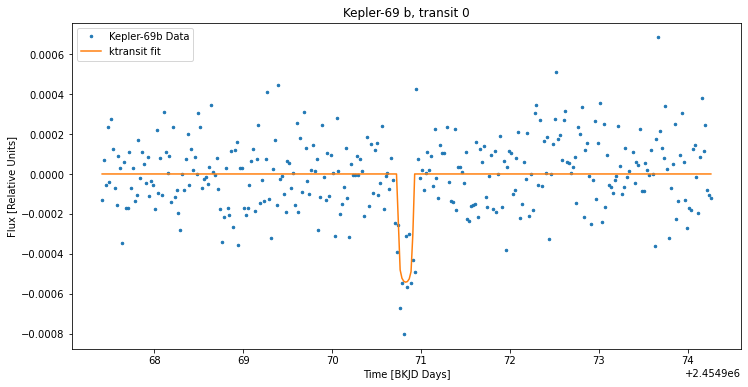

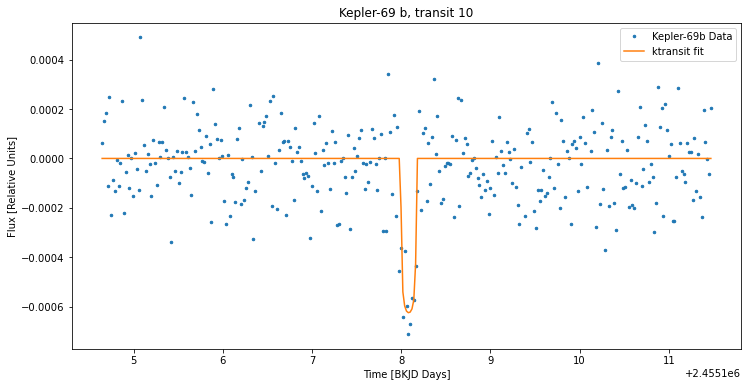

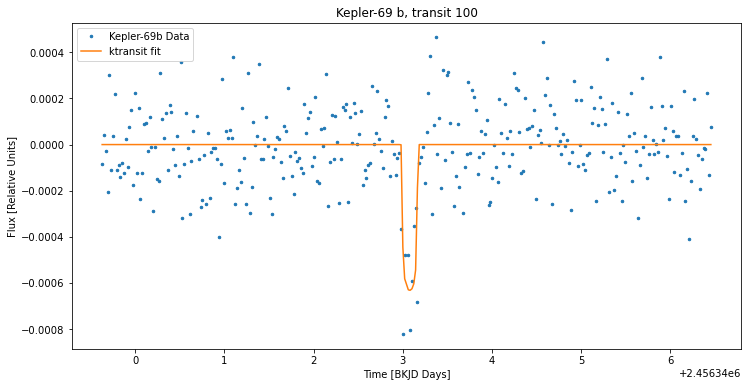

In [218]:
# fit one transit

def fit_ktransit(transit_idx, to_plot):
    
    # area around expected transit
    low_bound = t0 + period * transit_idx - period/4     # /4 is somewhat arbitrary
    up_bound = t0 + period * transit_idx + period/4
    interval = (low_bound < time)*(time < up_bound)
    length = len(time[interval])

    fitT = FitTransit()
    fitT.add_guess_star()    
    fitT.add_guess_planet(period=period, impact=impact_parameter, T0=t0 + period, rprs=R_p_star)
    fitT.add_data(time=time[interval], flux=flux[interval] - 1, ferr=err[interval])

    vary_star = []                     # free stellar parameters
    vary_planet = (['T0',  'rprs'])    # free planetary parameters

    fitT.free_parameters(vary_star, vary_planet)
    fitT.do_fit()                      # run the fitting
    
    print('Transit ' + str(transit_idx) + ':')
    fitT.print_results()               # print some results
    RMSE = np.sqrt(np.sum(((flux[interval] - 1) - fitT.transitmodel)**2/length))
    print('RMSE = ' + str(np.round(RMSE,4)))
    print()
    
    if to_plot:
        #fig = ktransit.plot_results(time[(low_bound < time)*(time < up_bound)],flux[(low_bound < time)*(time < up_bound)]-1,fitT.transitmodel) 
        #plt.title('Kepler-69 b, transit ' + str(transit_idx))
        #fig.show()
        plt.figure(figsize = [12,6])
        plt.plot(time[interval],flux[interval] - 1 , '.', markersize = 5,label = 'Kepler-69b Data')
        plt.plot(time[interval], fitT.transitmodel, label = 'ktransit fit')
        plt.legend()
        plt.xlabel('Time [BKJD Days]')
        plt.ylabel('Flux [Relative Units]')
        plt.title('Kepler-69 b, transit ' + str(transit_idx))
    
fit_ktransit(0,1)
fit_ktransit(10,1)
fit_ktransit(100,1)